Copyright (C) 2017 The HDF Group

This example code illustrates how to access and visualize GESDISC
CMS product in Python via OPeNDAP.

If you have any questions, suggestions, or comments on this example, please use the HDF-EOS Forum (http://hdfeos.org/forums).

If you would like to see an example of any other NASA HDF/HDF-EOS data
product that is not listed in the HDF-EOS Comprehensive Examples page
(http://hdfeos.org/zoo), feel free to contact us at eoshelp@hdfgroup.org or post it at the HDF-EOS Forum (http://hdfeos.org/forums).

Tested under: Python 2.7.10 :: Anaconda 2.3.0 (x86_64)

Last updated: 2017-2-09

# Subset and Aggregate CMS data from GES DISC via OPeNDAP using CMR search result

In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
import netcdf4_pydap

We will use NASA Core Metadata Repository (CMR) search engine. The netCDF4 (HDF5) file must be searchable by CMR and served by OPeNDAP server. Please download and install PyCMR from https://github.com/hdfeos/cmr

In [2]:
from pyCMR import CMR

# Change path to the sample cmr.cfg file.
# cmr=CMR("C:\\temp\\cmr.cfg")
cmr=CMR("/Users/hyoklee/cmr/cmr.cfg")

# AIRS granule search doesn't return OPeNDAP URL.
# Retrieve the entire granule collection from search result.
results_g = cmr.searchGranule(short_name="CMS_CH4_FLX_NA")

# Collection does return OPeNDAP URL.
results = cmr.searchCollection(limit=1,short_name="CMS_CH4_FLX_NA")
for res in results:
    ourl = res.getOPeNDAPUrl()
    
# Examine the OPeNDAP URL.
print ourl

# Replace http to https. 
ourl = ourl.replace("http:", "https:")

# There are 24 months of granules (files) from 2010/01 ~ 2011/12.
ourls = []

print len(results_g)
for res in results_g:
    durl = res.getDownloadUrl()
    # Download URL doesn't match OPeNDAP URL.
    # 
    # Downlaod URL example:
    # http://acdisc.gesdisc.eosdis.nasa.gov/data//CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201001.nc
    # 
    # OPeNDAP URL:
    # http://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/
    #
    # We need to cut and append to generate valid OPeNDAP resource URL.
    # For example, cut 2010/CH4_flux_201001.nc from download URL
    # and paste it to OPeNDAP URL.
    fname = durl.rsplit('/', 2)

    ourls.append(ourl+fname[1]+'/'+fname[2])

http://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/
24


  From the collection of OPeNDAP data URLs, we will examine the contents of CMS file using the first URL. Examining one file is enough because the collection shares the same content structure. 

In [3]:
# We will use netcdf4_pydap for Windows users who may have diffculty
# in accessing data with netCDF4-python because of URS. 
credentials={'username': 'eoshelp',
             'password': '*******',
             'authentication_url':'https://urs.earthdata.nasa.gov/'}


# List available variables.
nc0 = netcdf4_pydap.Dataset(ourls[0])
print nc0.variables

# Save the variable name of interest. 
DATAFIELD_NAME = 'emissions'

# Save the latitude and longitude variables.
latitude = nc0.variables['lat'][:]
longitude = nc0.variables['lon'][:]

# List available global attributes.
print nc0.ncattrs()

# Examine the content of attribute.
print nc0.getncattr('NOTE-1')

# The above prints information that Rice's index is the 7th in the first
# dimesion (size=9) of emssions[9][121][151] variable.

# Save unit information for plot.
emission_units = nc0.variables[DATAFIELD_NAME].getncattr('Unit')
nc0.close()

{'lat': <type 'instance'>
float32 lat(lat)
    Unit: degrees
unlimited dimensions: 
current shape = (121,)
, 'yr': <type 'instance'>
float32 yr(dat)
unlimited dimensions: 
current shape = (1,)
, 'lon': <type 'instance'>
float32 lon(lon)
    Unit: degrees
unlimited dimensions: 
current shape = (151,)
, 'mon': <type 'instance'>
float32 mon(dat)
unlimited dimensions: 
current shape = (1,)
, 'emissions': <type 'instance'>
float32 emissions(ems, lat, lon)
    Unit: Gg/yr
unlimited dimensions: 
current shape = (9, 121, 151)
}
['emission_date', 'creation_date', 'NOTE-1', 'NOTE-3', 'NOTE-2']
1-Total, 2-Wetlands, 3-Livestock, 4-Oil/Gas, 5-Waste, 6-Coal, 7-Rice, 8-OpenFires, 9-Other


  Let's find the highest value for Rice emission in the entire CMS collection.

In [4]:
max = -9999999999.0

for FILE_NAME in ourls:
    print FILE_NAME
    nc = netcdf4_pydap.Dataset(FILE_NAME, **credentials) 
    # nc = Dataset(FILE_NAME)
    dset = nc.variables[DATAFIELD_NAME][6,:,:]
    a_max = dset.max()
    if a_max > max:
        # Save the location where Rice value is the highest.
        indices = np.where(dset == a_max)
        max = a_max
        print a_max
        print indices
    # If you don't close here, you'll get an error after 7th OPeNDAP request.
    nc.close()        

https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201001.nc
0.382627335253
(array([0]), array([40]), array([72]))
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201002.nc
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201003.nc
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201004.nc
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201005.nc
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201006.nc
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201007.nc
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201008.nc
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201009.nc
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201010.nc
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201011.nc
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS

Collect the historical (2010/01 ~ 2011/12) value of Rice at the same location that has the highest emission value.

In [5]:
rice_vals = []
year_months = []
for FILE_NAME in ourls:
    print FILE_NAME
    nc = netcdf4_pydap.Dataset(FILE_NAME, **credentials)
    fname = os.path.basename(FILE_NAME)
    dset = nc.variables[DATAFIELD_NAME][6,:,:]
    val = dset[indices]
    nc.close()
    print val
    rice_vals.append(val[0])
    year_months.append(fname[9:15])
print rice_vals
print year_months

https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201001.nc
[ 0.38262734]
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201002.nc
[ 0.34581045]
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201003.nc
[ 0.34787145]
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201004.nc
[ 0.25163569]
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201005.nc
[ 0.18290264]
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201006.nc
[ 0.21577843]
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201007.nc
[ 0.29294732]
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201008.nc
[ 0.35110641]
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201009.nc
[ 0.34262214]
https://acdisc.gsfc.nasa.gov/opendap/CMS/CMS_CH4_FLX_NA.1/2010/CH4_flux_201010.nc
[ 0.29362071]
https://acdisc.gsfc.nasa.gov/opendap/CMS

 We aggregated all data from 2 years of collection. Let's see how emission changes over time by plotting data over time.

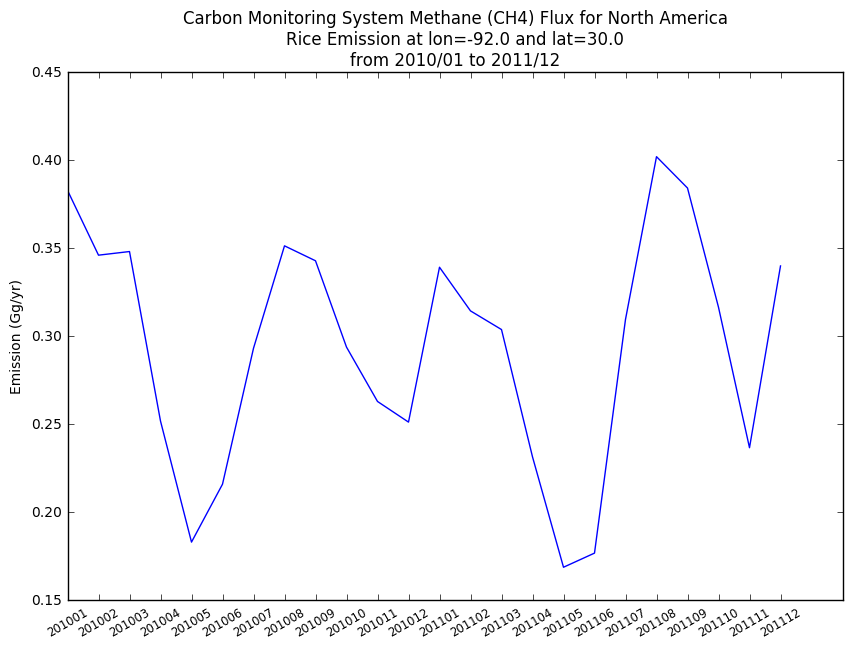

In [6]:
fig = plt.figure(figsize = (10, 15))
ax1 = plt.subplot(2, 1, 1)
plt.plot(rice_vals)
plt.ylabel('Emission ({0})'.format(emission_units))
plt.xticks(range(len(year_months)), year_months, size='small', rotation=30)
basename = os.path.basename(FILE_NAME)

# Set title from [1].
lat = latitude[indices[1][0]]
lon = longitude[indices[2][0]]
plt.title('Carbon Monitoring System Methane (CH4) Flux for North America\nRice Emission at lon={0} and lat={1}\nfrom 2010/01 to 2011/12'.format(lon, lat))
plt.show()

 Let's plot the location on world map so that we can easily see where the peak value occurred. 

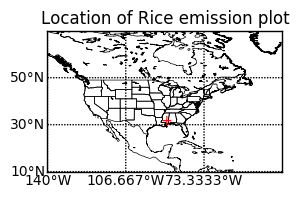

In [7]:
ax2 = plt.subplot(2, 1, 2)
latmin = np.min(latitude)
latmax = np.max(latitude)
lonmin = np.min(longitude)
lonmax = np.max(longitude)
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=latmin, urcrnrlat = latmax,
            llcrnrlon=lonmin, urcrnrlon = lonmax)

# load the shapefile, use the name 'states'
# https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html
m.readshapefile('cb_2015_us_state_20m', name='states', drawbounds=True)
m.drawcoastlines(linewidth=0.5)                
m.drawparallels(np.arange(latmin, latmax, (latmax-latmin)/3),
               labels=[True,False,False,True])
m.drawmeridians(np.arange(lonmin, lonmax, (lonmax-lonmin)/3),
                labels=[True,False,False,True])    
plt.text(lon, lat, '+', color='red')
plt.title('Location of Rice emission plot')
plt.show()
fig = plt.gcf()
pngfile = "{0}.py.png".format(basename)
fig.savefig(pngfile)

It seems that Lousiana is the winner in CH4 emission from rice. Compare it with the USDA map.

![2010_us_rice_production](https://upload.wikimedia.org/wikipedia/commons/9/9f/2010_US_rice_production.svg)

# References
1 https://acdisc.gesdisc.eosdis.nasa.gov/data/CMS/CMS_CH4_FLX_NA.1/doc/README.CMS_CH4_FLX_NA_V1.pdf